# Performing an A/B Test to finalize Website Design

## Introduction

This notebook is part of a project to showcase a working example of an A/B Test. These tests are performed when there are different versions of a strategy or a product to select from, and a team requires some metrics to finalize which of the versions to choose.

It is also a structured analysis notebook that shows how data analysis is expected to be done on a singular non-production environment. We will start by importing the necessary libraries and I will give a brief walkthrough of the problem we are trying to solve.

**Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from scipy.stats import norm

## Problem Statement

The task is to redesign the landing page of a website. The landing page is generally where user traffic originates from. For instance, if your product has a purchase or subscription plan, the landing page is the source from where people navigating your website will go to the subscription initiation page. The aim here is that a new design should increase the number of people who click through and join your site.

To solve this problem, we will perform an A/B test to compare the initial user reception of the new landing page with and without the new set of images which form three different designs, built on top of the old design. **Our metric will be the conversion rate and we will perform a Z-test to see if the metric is being met without significant errors.**

## Data

The input data is saved in a single .csv file, named 'redesign.csv'.

In [2]:
df = pd.read_csv('data/redesign.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   treatment   40484 non-null  object
 1   new_images  40484 non-null  object
 2   converted   40484 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 949.0+ KB


**Understanding the input**

The dataframe given in the input is composed of 3 columns and 40484 rows. The columns 'treatment' and 'new_images' are of type object while 'converted' is an int64. Moreover, there is no missing data in the dataframe. Below are the meanings of each of the columns:

- 'treatment' - "yes" if the user saw the new version of the landing page, no otherwise.
- 'new_images' - "yes" if the page used a new set of images, no otherwise.
- 'converted' - 1 if the user joined the site, 0 otherwise.

Each combination of the rows of 'treatment' and 'new_images' represents a group: 
1. Control Group - "NO" in 'Treatment' and "NO" in 'New Images' 
2. Experimental Group - 
                        "YES" in 'Treatment' and "NO" in 'New Images'
                        "NO" in 'Treatment' and "YES" in 'New Images' 
                        "YES" in 'Treatment' and "YES" in 'New Images'

In [3]:
# Let us form a new data point to understand treatment and new images.

groups = df.groupby(['treatment', 'new_images'])

How is the grouped data distributed? 
- Are the groups of similar size? 
- How will grouping determine the probability of a user joining the website?

**Binomial Distribution**

Each variable, for which only two values are possible, follows a binomial distribution. The density plots below show the distribution of each variable and indeed all variables follow binomial distributions. 

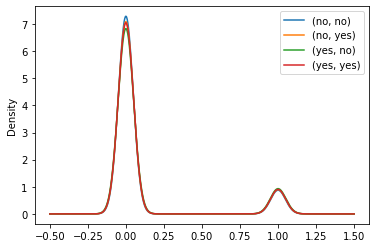

converted                
                         count      mean   sum
treatment new_images                          
no        no             10121  0.107104  1084
          yes            10121  0.112538  1139
yes       no             10121  0.120047  1215
          yes            10121  0.113724  1151

In [4]:
groups['converted'].plot.kde()
plt.legend()
plt.show()

results = groups.agg({'converted':['count', 'mean', 'sum']})
results

We notice that the groups have exactly the same size, 10121 rows. The probability of a user joining the site changes with the design, with the control group being the less sucessful. At this point, it seems like redesigning was a good idea because the experimental group shows better success rate. 

However, the difference we want to measure is between 0.5 and 1.3%, which is very small.

## Methodology

### Summary

This is a classic A/B test problem. The approach I explain here will be to calculate the conversion rate (user coming to the landing page and going through with a purchase) of both the landing pages. Statistically, since the problem only wants to increase the number of customers, we will use the one-tailed hypothesis test. The metric of measure is the conversion rate and additionally, we will use the z-test to establish a confidence interval in which our test will not give any errors (type II)

The general workflow of testing any hypothesis follows the same set of steps and instructions. We start with the null hypothesis, introduce evidence to compare the null hypothesis with an alternate hypothesis. Then, we conclude if the new evidence could confidently overturn the null hypothesis. In either scenario, we should always make it a point to test the analysis for possible errors.

In [5]:
# Define the significance level for acceptance
alpha = 0.05

# Cohen's d is an effect size used to indicate the standardised difference between two means.
def cohen_d(param_one, param_two):
    std = np.sqrt((np.std(param_one)**2 + np.std(param_two)**2)/2)
    mean = np.mean(param_two) - np.mean(param_one)
    return np.abs(mean/std)

# Power analysis
def do_power(param_one, param_two, alpha, num_obs=10121, ratio=1.0, alternative='larger'):
    effect_size = cohen_d(param_one,param_two)
    return NormalIndPower().power(effect_size=effect_size, nobs1 = num_obs, alpha=alpha,
                                  ratio=ratio, alternative=alternative)

results[('converted', 'power_score')] = ""

group_ctrl = groups.get_group(("no", "no"))

for key in list(groups.groups.keys())[1:]:
    group_exp = groups.get_group(key)
    power = do_power(group_ctrl['converted'], group_exp['converted'], alpha)
    results.loc[key, ('converted', 'power_score')] = power   
    
results

converted                            
                         count      mean   sum power_score
treatment new_images                                      
no        no             10121  0.107104  1084            
          yes            10121  0.112538  1139    0.341483
yes       no             10121  0.120047  1215    0.895739
          yes            10121  0.113724  1151    0.443471

Tipically, a power level of 0.8 is a good value. The group (yes, no) is the only with a larger value than 0.8. 
As for the size of the samples, ideally they should be even larger. As a result, we will use the whole samples.

In [6]:
# Preprocess parameters to make them ready for the z-score test
def preprocess(experiment, control):
    mean_one = experiment["converted"].mean()
    sum_one = experiment["converted"].std()
    count_one = experiment["converted"].count()
    
    mean_two = control["converted"].mean()
    sum_two = control["converted"].std()
    count_two = control["converted"].count()
    
    return [mean_one, sum_one, count_one], [mean_two, sum_two, count_two]

# Calculate the z-scores on the experiment and control groups
def zscore_test(experiment, control, val=0):
    
    exp, ctrl = preprocess(experiment, control)
    
    return (exp[0] - ctrl[0] - val)/(np.sqrt(exp[1]**2/exp[2] + ctrl[1]**2/ctrl[2]))

# Calculate lower bound of confidence intervals for the test
def confidence(experiment, control, Z):
    exp, ctrl = preprocess(experiment, control)
    lower_interval = (exp[0] - ctrl[0]) - Z * (np.sqrt(exp[1]**2/exp[2] + ctrl[1]**2/ctrl[2]))
    return lower_interval

# Calculate the z-score's alpha value to reject null hypothesis
z_alpha = norm.ppf(1-alpha)
print("z_alpha: {}".format(z_alpha))
results[('converted', 'z_score')] = ""

group_ctrl = groups.get_group(("no", "no"))

for key in list(groups.groups.keys())[1:]:
    group_exp = groups.get_group(key)
    zscore = zscore_test(group_exp, group_ctrl)
    results.loc[key, ('converted', 'z_score')] = zscore   
    
results

z_alpha: 1.6448536269514722


converted                                      
                         count      mean   sum power_score   z_score
treatment new_images                                                
no        no             10121  0.107104  1084                      
          yes            10121  0.112538  1139    0.341483  1.236372
yes       no             10121  0.120047  1215    0.895739  2.902351
          yes            10121  0.113724  1151    0.443471  1.502605

We can only discard the null hypothesis for the group (yes, no).

In [8]:
control = groups.get_group(("no", "no"))
experiment = groups.get_group(("yes", "no"))

lower = np.round(confidence(experiment, control, z_alpha) * 100, 2)

print("With 95% confidence, we can state that the improvement of the design (YES, NO) compared to the control group was {}%.".format(lower))

print("\nFor (1) to be true, the probability of committing a Type I Error in reaching the above conclusion is about {}%.".format(alpha*100))

print("\nFor (1) to be true, the probability of committing a Type I Error in reaching the above conclusion is about {}%.".format(np.round( (1 - results.loc[("yes", "no"), ("converted", "power_score")]) * 100, 2)))

With 95% confidence, we can state that the improvement of the design (YES, NO) compared to the control group was 0.56%.

For (1) to be true, the probability of committing a Type I Error in reaching the above conclusion is about 5.0%.

For (1) to be true, the probability of committing a Type I Error in reaching the above conclusion is about 10.43%.


## Conclusion

This story talks about hypothesis testing, confidence intervals, z-scores, and A/B tests. These are important concepts in the statistical world that get used often in experiments revolving around data and specifically when organizations are looking to update their products. In the experiment I explained above, the organization is looking to modify their landing page to increase the traffic followed by an uplift in their subscriptions. Through our A/B tests, we concluded with 95% confidence that on seeing the new version of the landing page with old images, the chances of them joining the subscription improve by at least 0.56% (possibly more) in comparison to the old design. We also accounted for Type I and Type II errors to nullify the chances of incorrect analysis.